In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from tf_model import *
#from tf_model_evi import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import evidential_deep_learning as edl
import matplotlib.pyplot as plt
import datetime
from filters import *
import plotly as py
#import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#py.offline.init_notebook_mode(connected = True)
#from plotly import tools
import plotly.express as px
import tensorflow_probability as tfp
from keras import backend as K
import seaborn as sns
from timeit import default_timer as timer
import time

In [3]:
input_conf = 'confe'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal_2.pkl','rb') as f:
    raw_data = pkl.load(f)

#input_copy = input_data
input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)
activity_id = (annotation['activity_id'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')

training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

train_activity_id = activity_id[training_ids.values]
test_activity_id = activity_id[~(training_ids.values)]

2021-12-07 14:57:01.337240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 14:57:01.342620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 14:57:01.343276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 14:57:01.362765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
if input_conf == 'confa':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confb':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
                
if input_conf == 'confc':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'confe':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'RespNet':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
        test_dataset = test_dataset.batch(128)

    

In [6]:
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/confa/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/confb/best_model_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/confc/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(y_batch_test,output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)

#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/confd/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/confe/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)

#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'RespNet':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/MultiRespDL/DL_BASED_METHOD/SAVED_MODELS/respnet/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
        
#-------------------------------------------------------------------------------------------------------------------


2021-12-07 14:57:02.597450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


Model: "br_unet__multi_resp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 32)            16704     
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 64)            65088     
_________________________________________________________________
sequential_14 (Sequential)   (None, 16, 128)           223552    
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 256)            956384    
_________________________________________________________________
sequential_24 (Sequential)   (None, 8, 512)            3559136   
_________________________________________________________________
sequential_29 (Sequential)   (None, 8, 1024)           11081952  
_________________________________________________________________
sequential_34 (Sequential)   (None, 4, 128)    

In [7]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [8]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [9]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confd':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    

In [10]:
#Mean Absolute Error for confb is: 2.3595224375361052
#Root Mean Square Error for confb is: 2.962611863792384

In [11]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'RespNet':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
        
    

In [12]:
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))



Mean Absolute Error average wise for confe is: 2.3576470584085674
Root Mean Square Error average wise for confe is: 2.9587030071600093
Mean Absolute Error instantaneous wise for confe is: 2.9539403693379693
Root Mean Square Error instantaneous wise for confe is: 3.6911145914511407


In [13]:
edr_hrv = [np.array([]) for i in range(len(x_test_data))]
edr_rpeak = [np.array([]) for i in range(len(x_test_data))]
adr = [np.array([]) for i in range(len(x_test_data))]
for i in range(len(x_test_data)):
    arr = np.transpose(x_test_data[i])
    edr_hrv[i]=np.append(edr_hrv[i],arr[0])
    edr_rpeak[i]=np.append(edr_rpeak[i],arr[1])
    adr[i]=np.append(adr[i],arr[2])

In [14]:
final_edr_hrv = []
final_edr_rpeak = []
final_adr = []
for i in range(len(edr_hrv)):
    final_edr_hrv.append(scipy.signal.filtfilt(fbpB,fbpA , edr_hrv[i]))
    final_edr_rpeak.append(scipy.signal.filtfilt(fbpB,fbpA , edr_rpeak[i]))
    final_adr.append(scipy.signal.filtfilt(fbpB,fbpA , adr[i]))

In [15]:
hrv_duration , _ = extremas_extraction(final_edr_hrv)
rpeak_duration , _ = extremas_extraction(final_edr_rpeak)
adr_duration , _ = extremas_extraction(final_adr)

In [16]:
rr_hrv = (60*4)/hrv_duration.reshape(-1,1)
rr_rpeak = (60*4)/rpeak_duration.reshape(-1,1)
rr_adr = (60*4)/adr_duration.reshape(-1,1)

In [17]:
error_hrv = np.abs(rr_hrv - avg_ref_breath)
error_rpeak = np.abs(rr_rpeak - avg_ref_breath)
error_adr = np.abs(rr_adr - avg_ref_breath)

In [18]:
mae_hrv = np.mean(error_hrv)
mae_rpeak = np.mean(error_rpeak)
mae_adr = np.mean(error_adr)

print(mae_hrv)
print(mae_rpeak)
print(mae_adr)

3.266529397156253
3.468155060676451
3.152974735868695


In [19]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    error_modality = np.hstack((error_hrv , error_rpeak 
                      , error_adr, error_avg_breaths,error_inst_breaths))
    col_modality = ['RRint' , 'Rpeak' , 'ADR' , 'Avg RR','Inst RR']
    error_modality_df = pd.DataFrame(error_modality , columns = col_modality) 

<IPython.core.display.Javascript object>


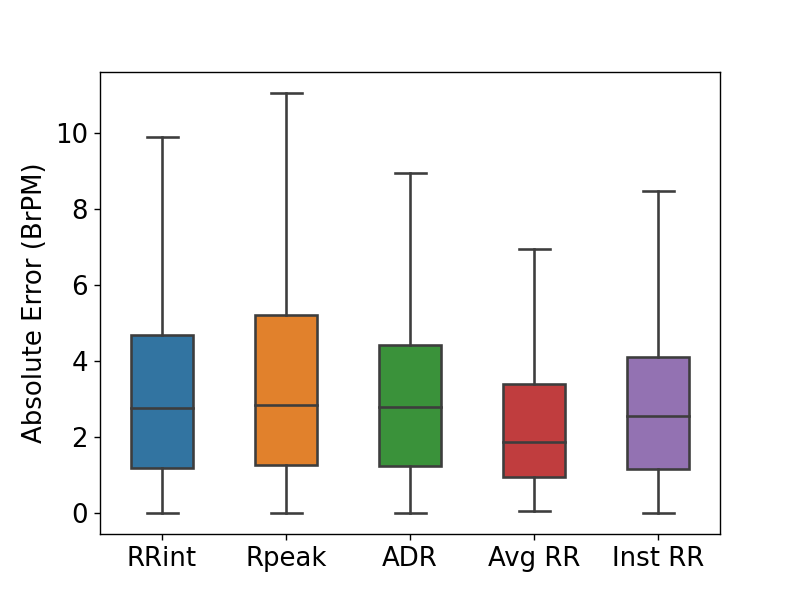

In [20]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    plt.figure(1)
    plt.rcParams["figure.figsize"] = (10,5)
    boxplot = sns.boxplot(data = error_modality_df , showfliers = False , width = 0.5)
    boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 0,fontsize=15)
    plt.ylabel('Absolute Error (BrPM)',fontsize=15)
    #plt.grid(True,axis = 'y')
    plt.yticks(fontsize=15)
    plt.show()
    #plt.savefig('modality_plot.png')

In [21]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    array_hrv = np.concatenate((error_hrv, np.array([0 for i in range(len(error_hrv))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_rpeak = np.concatenate((error_rpeak , np.array([1 for i in range(len(error_rpeak))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_adr = np.concatenate((error_adr , np.array([2 for i in range(len(error_adr))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_fusion = np.concatenate((error_inst_breaths , np.array([3 for i in range(len(error_inst_breaths))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)

<IPython.core.display.Javascript object>


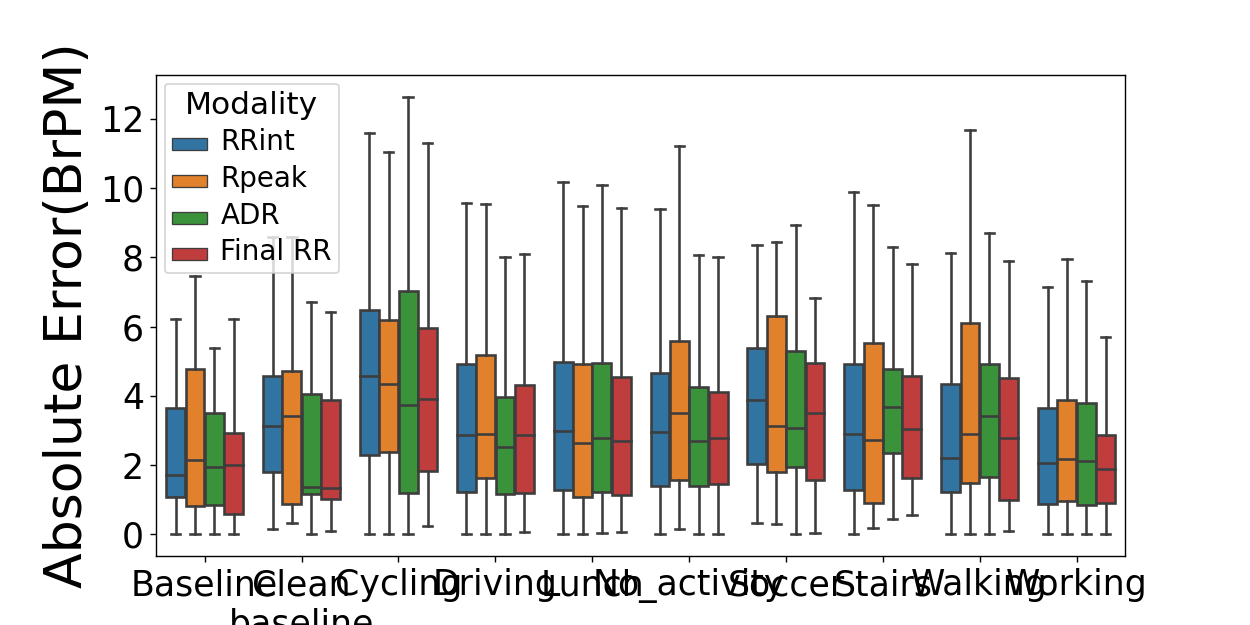

In [22]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    final_array = np.concatenate((array_hrv,array_rpeak,array_adr,array_fusion) , axis = 0)
    data_frame = pd.DataFrame(final_array , columns = ['Absolute Error(BrPM)' , 'Modality' , 'Activity_id'])
    data_frame['Modality'] = data_frame['Modality'].astype('category')
    data_frame['Activity_id'] = data_frame['Activity_id'].astype('category')
    data_frame['Modality'] = data_frame['Modality'].cat.rename_categories(['RRint' , 'Rpeak' , 'ADR' , 'Final RR'])
    data_frame['Activity_id'] = data_frame['Activity_id'].cat.rename_categories(['Baseline' , 'Clean'+'\n'+'baseline' , 'Cycling' , 'Driving','Lunch','No_activity',
                                                      'Soccer','Stairs', 'Walking', 'Working'])
    plt.figure(2)
    plt.rcParams["figure.figsize"] = (20,11)
    ax = sns.boxplot(x="Activity_id", y="Absolute Error(BrPM)", hue="Modality", data=data_frame , showfliers = False,width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 0,fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize=18)
    #ax.set_yticks([i for i in range(0, int(data_frame["Absolute Error(BrPM)"].max()), 4)])
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    plt.xlabel('Activity',fontsize = 30)
    plt.ylabel('Absolute Error(BrPM)',fontsize = 30)
    plt.yticks(fontsize=20)
    plt.show()
    plt.savefig('activity_plot.png')

In [23]:
def bland_altman_plot(predicted , truth):
    '''
    Inputs -- predicted -- Predicted Data
              Truth -- Reference Data
    Output -- None
    Description -- Function gives the bland altman plot.
    '''
    predicted = np.asarray(predicted)
    truth = np.asarray(truth)
    mean_val = np.mean([predicted , truth] , axis=0)
    diff = truth-predicted
    mean_diff = np.mean(diff)
    std_diff = np.std(diff , axis=0)
    print(mean_diff)
    print(mean_diff + 1.96*std_diff)
    print(mean_diff - 1.96*std_diff)
    plt.figure(3)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.scatter(mean_val , diff,marker = 'o',facecolors='none',edgecolors='b')
    plt.axhline(mean_diff , color = 'black' , linestyle = '-' , linewidth = 3)
    plt.axhline(mean_diff + 1.96*std_diff , color = 'black' , linestyle = '--', linewidth = 3)
    plt.axhline(mean_diff - 1.96*std_diff , color = 'black' , linestyle = '--', linewidth = 3)
    plt.xlabel('Instantaneous RR(BrPM)' , size = 15)
    plt.ylabel('RR_final - RR_ref(BrPM)' , size = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()
    #plt.savefig('bland_altman.png')

0.8812600232895413
[7.90662506]
[-6.14410501]


<IPython.core.display.Javascript object>


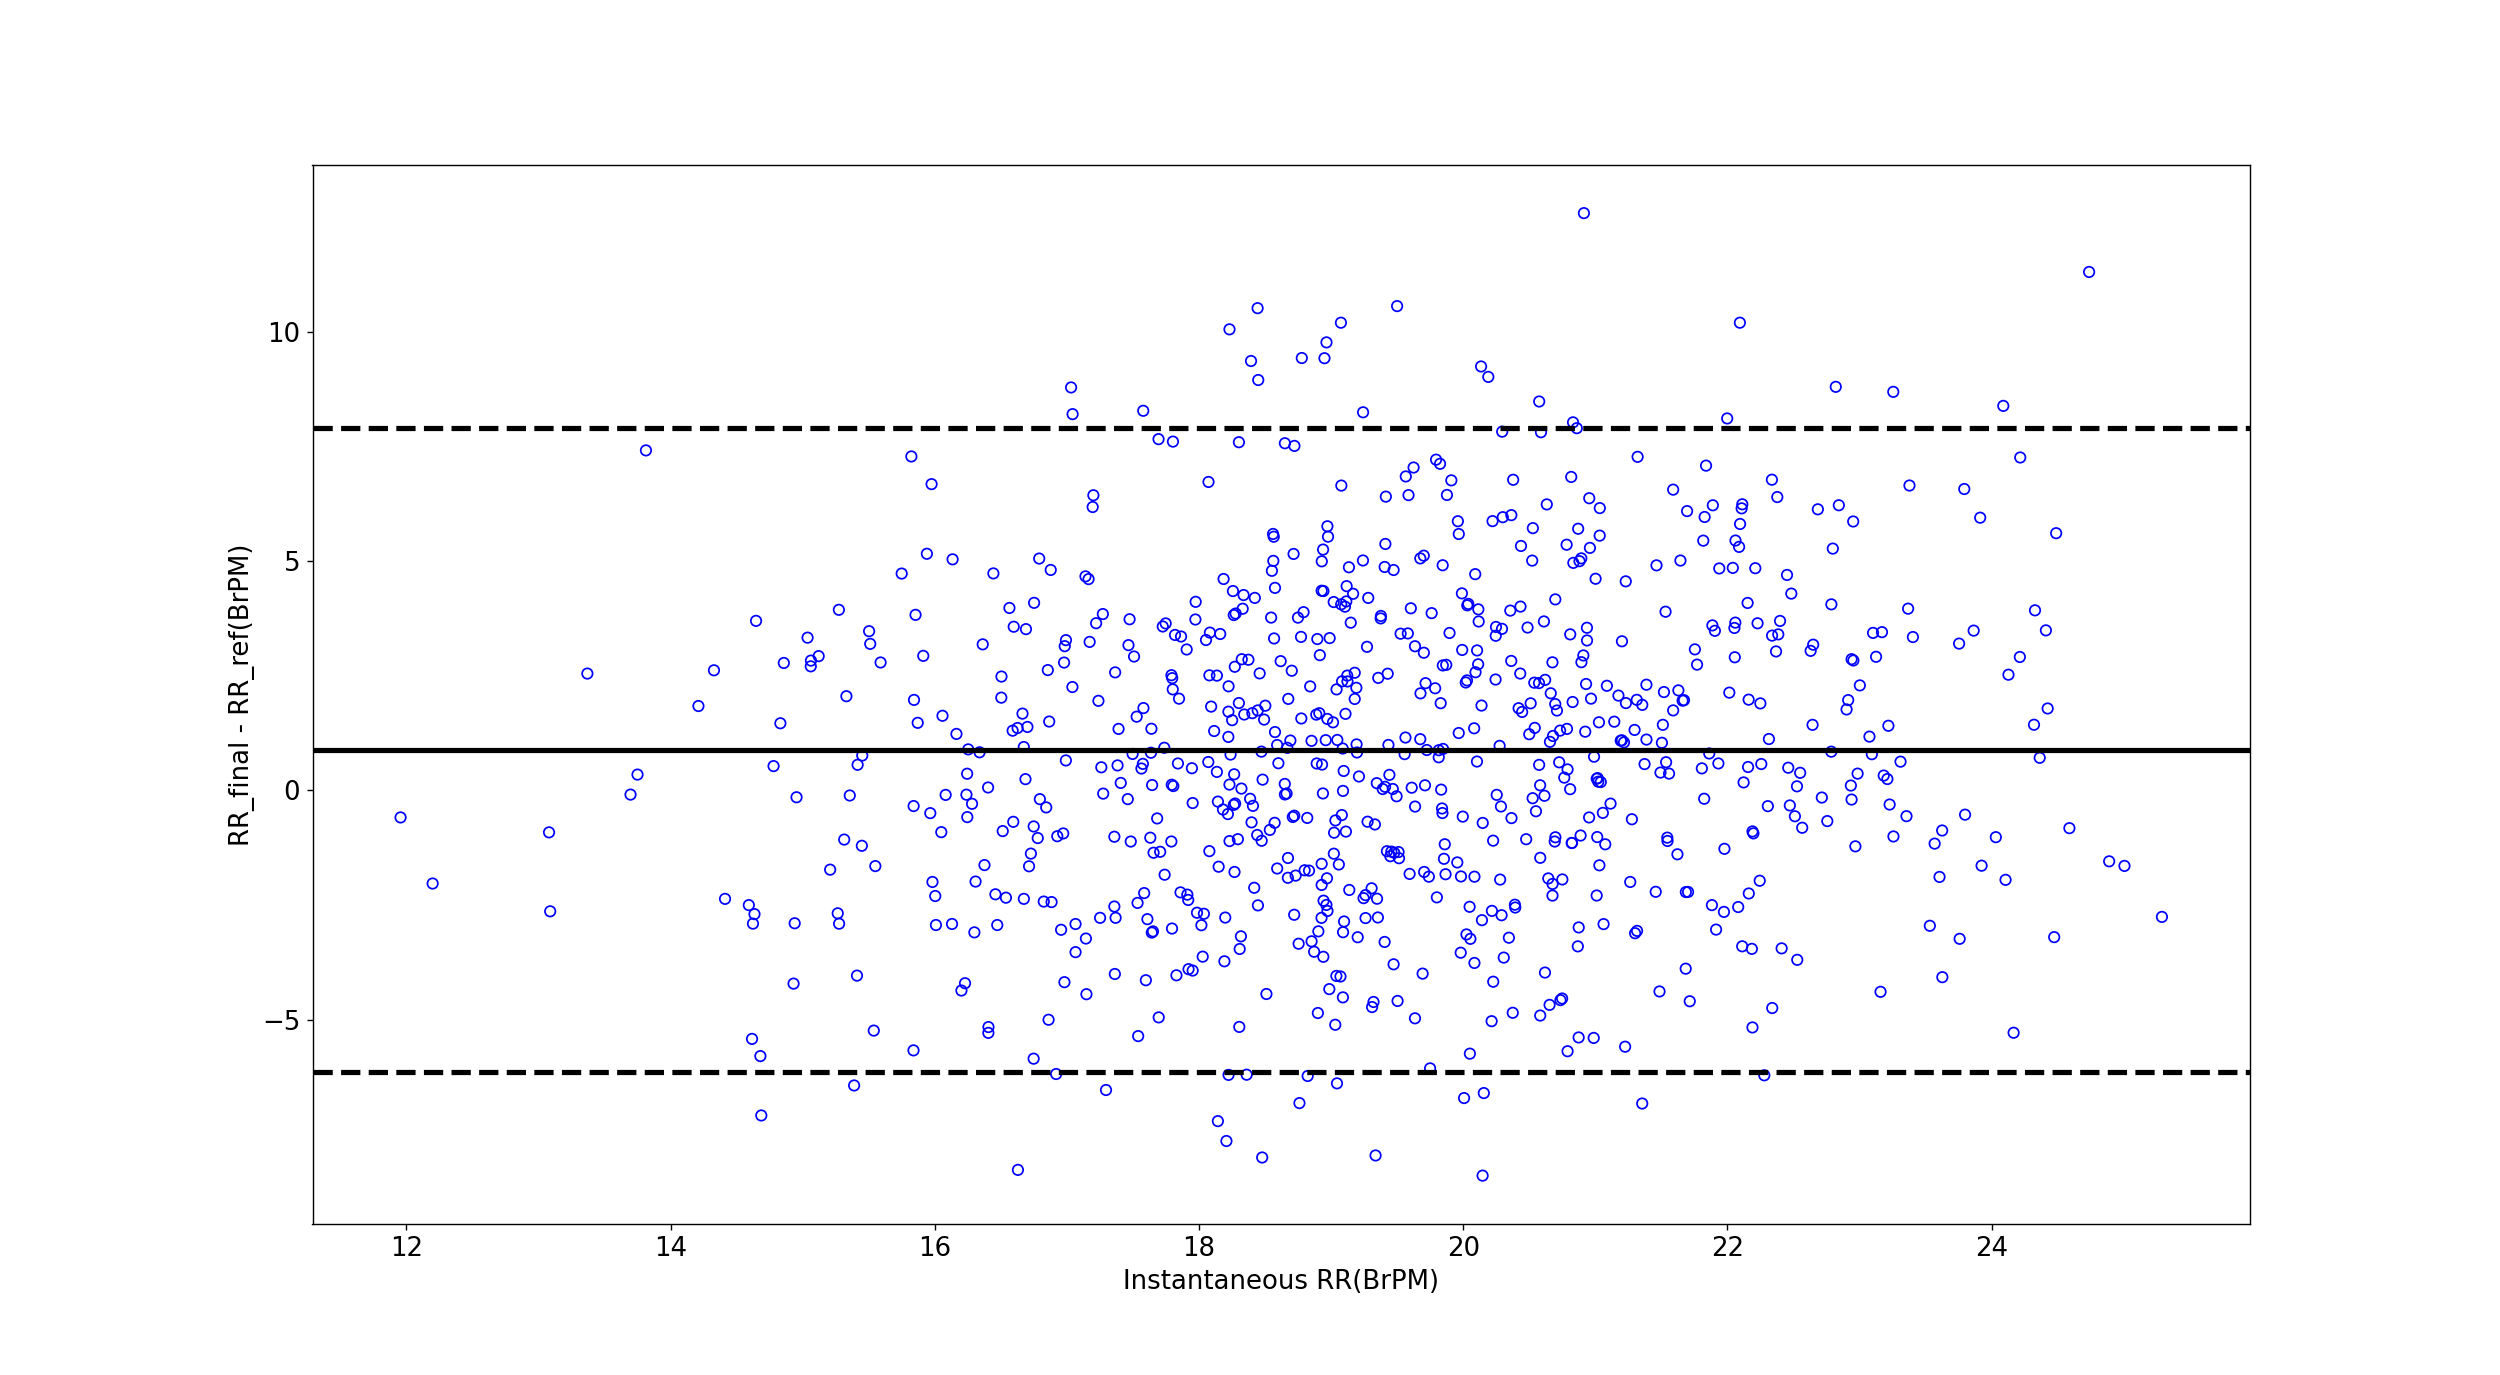

In [24]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    bland_altman_plot(inst_rr,inst_ref_rr)

In [25]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    error_baseline = error_inst_breaths[np.where(test_activity_id == 0)]
    error_stairs = error_inst_breaths[np.where(test_activity_id == 7)]
    error_soccer = error_inst_breaths[np.where(test_activity_id == 6)]
    error_cycling = error_inst_breaths[np.where(test_activity_id == 2)]
    error_driving = error_inst_breaths[np.where(test_activity_id == 3)]
    error_lunch = error_inst_breaths[np.where(test_activity_id == 4)]
    error_walking = error_inst_breaths[np.where(test_activity_id == 8)]
    error_working = error_inst_breaths[np.where(test_activity_id == 9)]

    error_baseline_hrv = error_hrv[np.where(test_activity_id == 0)]
    error_stairs_hrv = error_hrv[np.where(test_activity_id == 7)]
    error_soccer_hrv = error_hrv[np.where(test_activity_id == 6)]
    error_cycling_hrv = error_hrv[np.where(test_activity_id == 2)]
    error_driving_hrv = error_hrv[np.where(test_activity_id == 3)]
    error_lunch_hrv = error_hrv[np.where(test_activity_id == 4)]
    error_walking_hrv = error_hrv[np.where(test_activity_id == 8)]
    error_working_hrv = error_hrv[np.where(test_activity_id == 9)]

    error_baseline_rpeak = error_rpeak[np.where(test_activity_id == 0)]
    error_stairs_rpeak = error_rpeak[np.where(test_activity_id == 7)]
    error_soccer_rpeak = error_rpeak[np.where(test_activity_id == 6)]
    error_cycling_rpeak = error_rpeak[np.where(test_activity_id == 2)]
    error_driving_rpeak = error_rpeak[np.where(test_activity_id == 3)]
    error_lunch_rpeak = error_rpeak[np.where(test_activity_id == 4)]
    error_walking_rpeak = error_rpeak[np.where(test_activity_id == 8)]
    error_working_rpeak = error_rpeak[np.where(test_activity_id == 9)]

    error_baseline_adr = error_adr[np.where(test_activity_id == 0)]
    error_stairs_adr = error_adr[np.where(test_activity_id == 7)]
    error_soccer_adr = error_adr[np.where(test_activity_id == 6)]
    error_cycling_adr = error_adr[np.where(test_activity_id == 2)]
    error_driving_adr = error_adr[np.where(test_activity_id == 3)]
    error_lunch_adr = error_adr[np.where(test_activity_id == 4)]
    error_walking_adr = error_adr[np.where(test_activity_id == 8)]
    error_working_adr = error_adr[np.where(test_activity_id == 9)]

In [26]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    print('stairs mean abs error hrv {}'.format(np.mean(np.abs(error_stairs_hrv))))
    print('stairs mean abs error rpeak {}'.format(np.mean(np.abs(error_stairs_rpeak))))
    print('stairs mean abs error adr {}'.format(np.mean(np.abs(error_stairs_adr))))
    print('stairs mean abs error fusion {}'.format(np.mean(np.abs(error_stairs))))
    print('-----------------------------------------------------------')
    print('cycling mean abs error hrv {}'.format(np.mean(np.abs(error_cycling_hrv))))
    print('cycling mean abs error rpeak {}'.format(np.mean(np.abs(error_cycling_rpeak))))
    print('cycling mean abs error adr {}'.format(np.mean(np.abs(error_cycling_adr))))
    print('cycling mean abs error fusion {}'.format(np.mean(np.abs(error_cycling))))
    print('-----------------------------------------------------------')
    print('walking mean abs error hrv {}'.format(np.mean(np.abs(error_walking_hrv))))
    print('walking mean abs error rpeak {}'.format(np.mean(np.abs(error_walking_rpeak))))
    print('walking mean abs error adr {}'.format(np.mean(np.abs(error_walking_adr))))
    print('walking mean abs error fusion {}'.format(np.mean(np.abs(error_walking))))
    print('-----------------------------------------------------------')
    print('baseline mean abs error hrv {}'.format(np.mean(np.abs(error_baseline_hrv))))
    print('baseline mean abs error rpeak {}'.format(np.mean(np.abs(error_baseline_rpeak))))
    print('baseline mean abs error adr {}'.format(np.mean(np.abs(error_baseline_adr))))
    print('baseline mean abs error fusion {}'.format(np.mean(np.abs(error_baseline))))
    print('-----------------------------------------------------------')
    print('Driving mean abs error hrv {}'.format(np.mean(np.abs(error_driving_hrv))))
    print('Driving mean abs error rpeak {}'.format(np.mean(np.abs(error_driving_rpeak))))
    print('Driving mean abs error adr {}'.format(np.mean(np.abs(error_driving_adr))))
    print('Driving mean abs error fusion {}'.format(np.mean(np.abs(error_driving))))

stairs mean abs error hrv 3.822254195224879
stairs mean abs error rpeak 3.4787966874727174
stairs mean abs error adr 4.275353993282093
stairs mean abs error fusion 3.3012603667673157
-----------------------------------------------------------
cycling mean abs error hrv 4.4447008284498
cycling mean abs error rpeak 4.493902171951423
cycling mean abs error adr 4.2591611065977295
cycling mean abs error fusion 4.204700540510041
-----------------------------------------------------------
walking mean abs error hrv 3.0955062714006365
walking mean abs error rpeak 3.9253230280936506
walking mean abs error adr 3.4335348732344144
walking mean abs error fusion 2.91459298079204
-----------------------------------------------------------
baseline mean abs error hrv 2.2801591446564937
baseline mean abs error rpeak 2.808892323908228
baseline mean abs error adr 2.325681799732599
baseline mean abs error fusion 2.0497573356370604
-----------------------------------------------------------
Driving mean ab